# Run the simulation notebook for one set of parameters


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from gammapy.datasets import Datasets
from gammapy.estimators import ExcessMapEstimator
from simulation_extended import *
from regions import CircleSkyRegion
from gammapy.makers import FoVBackgroundMaker

In [2]:
simulator = Simulation()
estimator = ExcessMapEstimator(correlation_radius=0.1*u.deg,
                             selection_optional=None)

The number of simulated obs is 4*n_obs, ie, n_obs is the number of runs simulated at each wobble position. For now, it is the same.
Can make it a list if really necessary

In [3]:
%%time
sigma = 2.0*u.deg
A0 = 5e-11
n_obs = 5
datasets = simulator.run(n_obs=n_obs, sigma=sigma, A0=A0)

Pointing position: 
 <SkyCoord (Galactic): (l, b) in deg
    (0.7, 0.)>
Pointing position: 
 <SkyCoord (Galactic): (l, b) in deg
    (359.3, 0.)>
Pointing position: 
 <SkyCoord (Galactic): (l, b) in deg
    (0., 0.7)>
Pointing position: 
 <SkyCoord (Galactic): (l, b) in deg
    (0., -0.7)>
CPU times: user 30.2 s, sys: 5.93 s, total: 36.1 s
Wall time: 36.2 s


(array([1., 0., 1., 3., 1., 6., 2., 4., 1., 1.]),
 array([0.67014198, 0.72820382, 0.78626566, 0.84432749, 0.90238933,
        0.96045117, 1.018513  , 1.07657484, 1.13463667, 1.19269851,
        1.25076035]),
 <BarContainer object of 10 artists>)

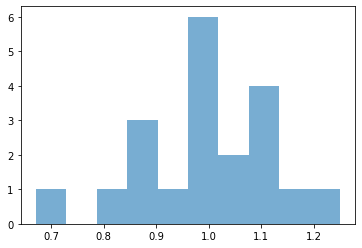

In [4]:
# The injected background systematics are stored in bkg_norms
plt.hist(simulator.bkg_norms, alpha=0.6)

In [5]:
# Stack the datasets for visualisation
stacked = datasets.stack_reduce()

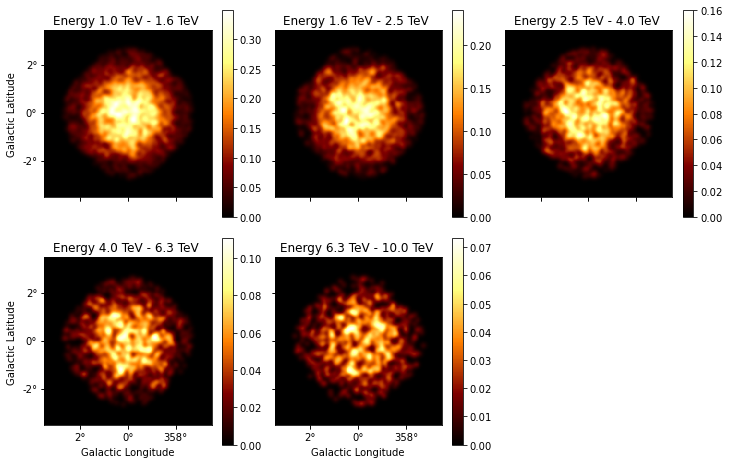

In [6]:
stacked.counts.smooth(0.1*u.deg).plot_grid(add_cbar=True);

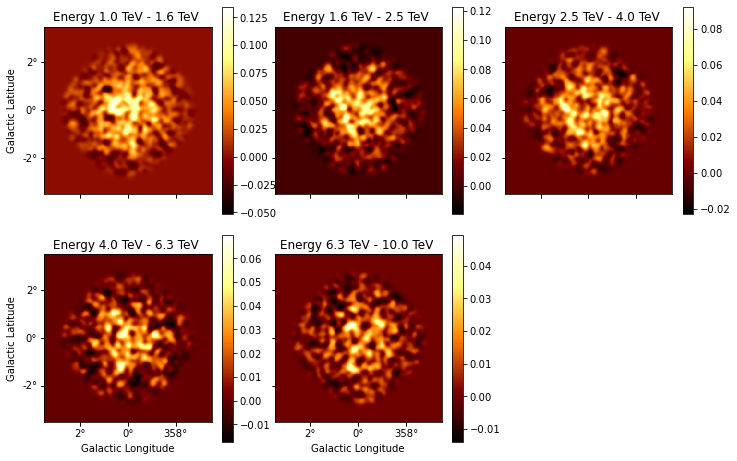

In [7]:
(stacked.counts - stacked.background).smooth(0.1*u.deg).plot_grid(add_cbar=True);

/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(<Figure size 432x288 with 2 Axes>,
 <WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>,
 <matplotlib.colorbar.Colorbar at 0x16fb98278>)

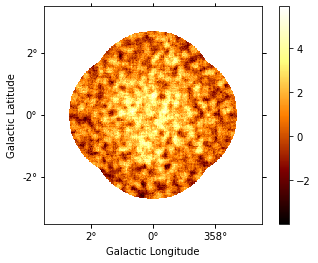

In [8]:
residual1 = estimator.run(stacked)
residual1['sqrt_ts'].plot(add_cbar=True)

In [9]:
#The injected model parameters
model = simulator.sky_model(sigma.value, A0)
model.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str8,float64,float64,bool,int64
amplitude,2.0000e-10,cm-2 s-1,nan,nan,False,0.000e+00
index,2.3000e+00,,nan,nan,False,0.000e+00
emin,1.0000e+00,TeV,nan,nan,True,0.000e+00
emax,1.0000e+01,TeV,nan,nan,True,0.000e+00
lon_0,0.0000e+00,deg,nan,nan,False,0.000e+00
lat_0,0.0000e+00,deg,-9.000e+01,9.000e+01,False,0.000e+00
sigma,2.0000e+00,deg,0.000e+00,nan,False,0.000e+00
e,0.0000e+00,,0.000e+00,1.000e+00,True,0.000e+00
phi,0.0000e+00,deg,nan,nan,True,0.000e+00


In [10]:
minor_axis = model.spatial_model.sigma.quantity * np.sqrt(1 - model.spatial_model.e.value ** 2)

surface_brightness = model.spectral_model.amplitude.quantity/(4*np.pi*minor_axis*model.spatial_model.sigma.quantity)
print(surface_brightness.to(1/(u.cm**2 * u.s * u.sr)))

1.3061871445445794e-08 1 / (cm2 s sr)


17129.0 12986.723018967652 0.31896244918617106


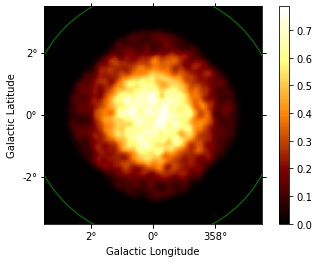

In [11]:
#Source strength as a fraction of background
region = CircleSkyRegion(center=simulator.skydir,
                        radius=2.0*sigma)
bkg_strength = stacked.background.get_spectrum(region).data.sum()
src_strength = stacked.counts.get_spectrum(region).data.sum()

fig, ax, _ = stacked.counts.sum_over_axes().smooth(0.1*u.deg).plot(add_cbar=True)
region.to_pixel(wcs=stacked._geom.wcs).plot(edgecolor='green');

print(src_strength, bkg_strength, (src_strength - bkg_strength)/bkg_strength)

## Extract with the ring background

In [12]:
from ring_background import *

In [13]:
mask = make_mask(datasets, 
                 source_pos=simulator.skydir, 
                 source_radius=2.0*sigma)

In [14]:
%%time
stacked_on_off = extract_ring_adaptive(datasets=datasets,
                              exclusion_mask=mask
                             )

/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


CPU times: user 27.3 s, sys: 5.7 s, total: 33 s
Wall time: 32.4 s


ValueError: zero-size array to reduction operation minimum which has no identity

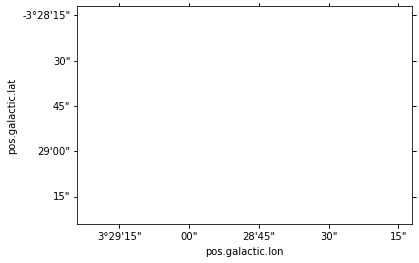

In [15]:
residual2 = estimator.run(stacked_on_off)
residual2['sqrt_ts'].plot(add_cbar=True)

In [ ]:
significance_map_off = residual2['sqrt_ts'] * mask
significance_all = residual2['sqrt_ts'].data[np.isfinite(residual2['sqrt_ts'].data)]
significance_off = significance_map_off.data[
    np.isfinite(significance_map_off.data)
]

plt.hist(
    significance_all,
    density=True,
    alpha=0.5,
    color="red",
    label="all bins",
    bins=21,
)

plt.hist(
    significance_off,
    density=True,
    alpha=0.5,
    color="blue",
    label="off bins",
    bins=21,
)

# Now, fit the off distribution with a Gaussian
mu, std = norm.fit(significance_off)
x = np.linspace(-8, 8, 50)
p = norm.pdf(x, mu, std)
plt.plot(x, p, lw=2, color="black")
plt.legend()
plt.xlabel("Significance")
plt.yscale("log")
plt.ylim(1e-5, 1)
xmin, xmax = np.min(significance_all), np.max(significance_all)
plt.xlim(xmin, xmax)

print(f"Fit results: mu = {mu:.2f}, std = {std:.2f}")

Now, fit using the ring background

In [ ]:
#define the sky_model to fit to the data
sky_model = model.copy(name='ring_fit')
sky_model.spectral_model.parameters['index'].frozen = True

In [ ]:
L0 = stacked_on_off.stat_sum()

In [ ]:
# Add the sky model to the dataset
stacked_on_off.models = sky_model

In [ ]:
# Now fit
fit = Fit([stacked_on_off])
result = fit.run()
print(result)

In [ ]:
print(result.parameters.to_table())

In [ ]:
L1 = stacked_on_off.stat_sum()
print('Detection del(TS) = ', L0-L1)

## Now, fit using 3D stacked analysis

- using background models

In [ ]:
#This is the background maker
# We fit the background before stacking
maker_fov = FoVBackgroundMaker(method="scale", 
                               exclusion_mask=mask)

In [ ]:
%%time
stacked3D = MapDataset.create(
    geom=datasets[0]._geom, 
    energy_axis_true=datasets[0].exposure.geom.axes['energy_true'], 
    name="stacked3D"
)
for dataset in datasets:
    dataset = maker_fov.run(dataset)
    stacked3D.stack(dataset)

In [ ]:
print(stacked3D)

In [ ]:
model3D = model.copy(name='model3D')
bkg_model3D = FoVBackgroundModel(dataset_name="stacked3D")

In [ ]:
stacked3D.models = bkg_model3D
L2 = stacked3D.stat_sum()

In [ ]:
stacked3D.models = [bkg_model3D, model3D]

In [ ]:
%%time
fit = Fit([stacked3D])
result = fit.run(optimize_opts={"print_level": 1})

In [ ]:
print(stacked3D.models.parameters.to_table())

In [ ]:
L3 = stacked3D.stat_sum()
print('Detection del(TS) = ', L2-L3)

## A joint 3D fitting

- This fits all the datasets together, 
- no stacking, it can be quite time consuming

In [ ]:
maker_fov = FoVBackgroundMaker(method="fit", 
                               exclusion_mask=mask)
model3D_joint = model.copy(name='model3D_joint')
datasets_fit = Datasets()
for dataset in datasets:
    dataset = maker_fov.run(dataset)
    bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
    dataset.models = [bkg_model, model3D_joint]
    datasets_fit.append(dataset)

In [ ]:
datasets_fit.models.names

In [ ]:
%%time
fit_joint = Fit(datasets_fit)
result_joint = fit_joint.run()

In [ ]:
model3D_joint.parameters.to_table()

### Compare the injected background systematics vs the recompted ones

In [ ]:
bkg_computed = []
bkg_err = []
for dataset in datasets_fit:
    bkg_computed.append(dataset.background_model.spectral_model.norm.value)
    bkg_err.append(dataset.background_model.spectral_model.norm.error)

In [ ]:
plt.errorbar(simulator.bkg_norms, bkg_computed, yerr=bkg_err, fmt='o')
plt.plot(simulator.bkg_norms, simulator.bkg_norms, ls='-')
plt.xlabel('simulated')
plt.ylabel('reconstructed')

In [ ]:

plt.hist(simulator.bkg_norms, alpha=0.5, label='injected')
plt.hist(bkg_computed, alpha=0.5, label = 'reconstructed')
plt.legend()

In [ ]:
## strength

In [ ]:
d0 = datasets[0]

In [ ]:
bkg = FoVBackgroundModel(dataset_name=d0.name)
bkg.spectral_model.norm.value = simulator.bkg_norms[0]
d0.models = [bkg, model]


In [ ]:
flux_model = d0.evaluators['model-simu'].compute_flux()

In [ ]:
flux_model.get_spectrum(region).data.sum()

In [ ]:
d0.background.get_spectrum(region).data.sum()

In [ ]:
d0.models[0].

In [ ]:
20 * 28 /60

In [ ]:
bkg.parameters.to_table()